In [128]:
import argparse
import os
import random

import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import pickle

## Dataset overview

In this problem we are building 15-way multi-class classifiers for a fruit classification task. The training and validation sets are stored in the .pkl files provided. See the hw5.pdf file we have provided for details.

In each dataset, we provide the following:
- 'images': the raw RGB images
- 'feats': 15 dimensional condensed representations of each image (that were precomputed by using a pretrained vision transformer + PCA)
- 'labels': an integer value between 0 and 14. The integer to class mapping is provided below in the variable 'idx_to_class'.

We first create a simple python dictionary that maps integers to textual class labels that can be useful for debugging.

In [129]:
idx_to_class = {0: 'Apple', 1: 'Banana', 2: 'Carambola', 3: 'Guava', 4: 'Kiwi', 5: 'Mango', 6: 'Orange', 7: 'Peach', 8: 'Pear', 9: 'Persimmon', 10: 'Pitaya', 11: 'Plum', 12: 'Pomegranate', 13: 'Tomatoes', 14: 'Muskmelon'}
print(idx_to_class)

{0: 'Apple', 1: 'Banana', 2: 'Carambola', 3: 'Guava', 4: 'Kiwi', 5: 'Mango', 6: 'Orange', 7: 'Peach', 8: 'Pear', 9: 'Persimmon', 10: 'Pitaya', 11: 'Plum', 12: 'Pomegranate', 13: 'Tomatoes', 14: 'Muskmelon'}


Next, we load the .pkl files that load as python dictionaries.

In [130]:
with open('train.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

In [131]:
with open('val.pkl', 'rb') as f:
    val_dataset = pickle.load(f)

In [132]:
with open('test_data.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

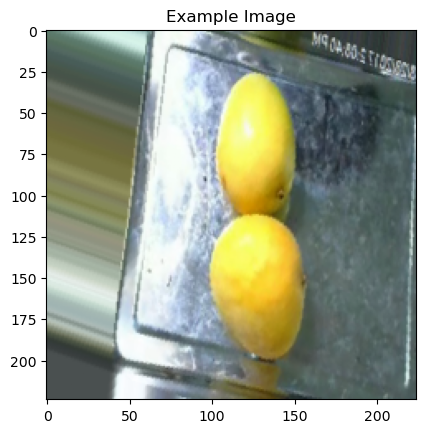

In [133]:
# We can plot the images this way. This will be quite useful for debugging.
plt.figure()
plt.title('Example Image')
plt.imshow(train_dataset['images'][0])
plt.show()

In [134]:
print("Examples Features shape:", train_dataset['feats'][0].shape)
print(type(train_dataset))
print(len(train_dataset['feats']))
print(len(train_dataset['labels']))
print(len(train_dataset['images']))
print(type(test_dataset))
print(len(test_dataset['feats']))
print(len(test_dataset['images']))

Examples Features shape: (15,)
<class 'dict'>
9876
9876
9876
<class 'dict'>
2116
2116


In [135]:
print("Example image label:", idx_to_class[train_dataset['labels'][0]])

X_train = np.array(train_dataset['feats'])
y_train = np.array(train_dataset['labels'])
print(X_train.shape)
print(y_train.shape)
X_train_images = np.array(train_dataset['images'])

X_valid = np.array(val_dataset['feats'])
y_valid = np.array(val_dataset['labels'])
print(X_valid.shape)
print(y_valid.shape)

X_test = np.array(test_dataset['feats'])
#X_test_images = np.array(test_dataset['images'])
print(X_test.shape)
#print(X_test_images.shape)

Example image label: Mango
(9876, 15)
(9876,)
(2116, 15)
(2116,)
(2116, 15)


## Part 2(a): Logistic Regression

Implement Logistic Regression from scratch and report your classifier's accuracy on the training and validation sets. **You should use your implementation from prior homeworks and turn it in again with updates, if any.**

In [136]:
# TODO: Implement multinomial logistic regression
class LogisticRegression:
    def __init__(self, learning_rate=0.05, stop_threshold=1.0e-4, eta=0.1):
        self.learning_rate = learning_rate
        self.stop_threshold = stop_threshold
        self.eta = eta
        self.W = None
        self.b = None
        self.loss = None
        self.loss_prev = []
    
    def fit(self, X, y):
        n, m = X.shape
        k = np.unique(y).size
        self.W = np.zeros((m, k))
        self.b = np.zeros((1, k))
        y_onehot = np.zeros((n, k))
        y_onehot[np.arange(n), y] = 1
        prev_loss = 0
        count = 0
        
        while True:
            z = np.dot(X, self.W) + self.b
            # logits
            Z = z - np.max(z, axis=1, keepdims=True)
            # softmax
            ki = np.exp(Z)
            y_hat = ki / np.sum(ki, axis=1, keepdims=True)
            # loss
            self.loss = np.mean(-np.log(y_hat[range(n), y])) + (self.eta/2)*(np.linalg.norm(self.W)**2)
            self.loss_prev.append(self.loss)
            if count > 1 and np.abs(self.loss - prev_loss) <= self.stop_threshold:
                break
            prev_loss = self.loss
            dW = np.dot(X.T, y_hat - y_onehot) / n + self.eta*self.W
            db = np.sum((y_hat - y_onehot), axis=0, keepdims=True) / n

            self.W -= self.learning_rate * dW
            self.b -= self.learning_rate * db
            
            count += 1
    
    def predict(self, X):
        z = np.dot(X, self.W) + self.b
        # logits
        Z = z - np.max(z, axis=1, keepdims=True)
        # softmax
        ki = np.exp(Z)
        y_hat = ki / np.sum(ki, axis=1, keepdims=True)
        return np.argmax(y_hat, axis=1)
    
# create an instance of the LogisticRegression class
lr = LogisticRegression(learning_rate=0.05, stop_threshold=1.0e-4, eta=0.1)

# fit the model to the training data
lr.fit(X_train, y_train)

# make predictions on the test data
y_pred = lr.predict(X_valid)

In [137]:
# TODO: Report accuracy on training and validation sets
def accuracy(y_pred, y_true):
    correct = 0
    wrong = 0
    for i in range(len(y_pred)):
        if (y_pred[i] == y_true[i]):
            correct += 1
        elif (y_pred[i] != y_true[i]):
            wrong += 1
    accuracy = correct / (correct + wrong)
    return accuracy

accuracy_valid = accuracy(y_pred,y_valid)
print("Accuracy on validation set: ", accuracy_valid)
y_pred_train = lr.predict(X_train)
accuracy_train = accuracy(y_pred_train, y_train)
print("Accuracy on training set: ", accuracy_train)

Accuracy on validation set:  0.7098298676748582
Accuracy on training set:  0.7128392061563386


## Part 2(b): Random Forest/GBDT 

Implement a random forest or GBDT from scratch and report your classifier's accuracy on the training and validation sets. **You should use your implementation from prior homeworks and turn it in again with updates, if any.**

In [126]:
################################## GBDT ###########################################

############################ finding best decision rule function ############################
def find_split_point_gbdt(train, target,residual, lmda=0, gamma=0):
    node =None
    best_feature = None
    best_val = None
    best_gain = 0
    num_featuress = train.shape[1]
    num_features = np.random.choice(num_featuress, size=int(0.5*num_featuress),replace=True)
    for feature in (num_features):
        feature_values = train[:, feature]
        feature_values_sorted = np.sort(feature_values)
        num_sorted = feature_values_sorted.shape[0]
        thresh = []
        if type(feature_values)==[int, float]:

            for j in range(num_sorted-1):
                thresh_val = (feature_values_sorted[j] + feature_values_sorted[j+1]) / 2
                thresh.append(thresh_val)

        else: 
            for j in range(train.shape[0]):
                thresh.append(feature_values[j])
        for val in thresh:
            left_child = {'X': [], 'y': []}
            right_child = {'X': [], 'y': []}
            left_indices =  np.where(feature_values<= val)[0]
            right_indices = np.where(feature_values > val)[0]
            
            if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                continue
            left_target=[]
            right_target=[]
            left_target = target[left_indices]
            left_train = train[left_indices]
            left_child['X'] = train[left_indices]
            left_child['y'] = target[left_indices]
            
            right_target = target[right_indices]
            right_train = train[right_indices]
            right_child['X'] = train[right_indices]
            right_child['y'] = target[right_indices]
            residual_left = residual[left_indices]
            residual_right = residual[right_indices]
        
            G_left, H_left = compute_loss_derivatives_gbdt(left_train, left_target, residual_left)
            G_right, H_right = compute_loss_derivatives_gbdt(right_train, right_target, residual_right)
            gain = ((((G_left**2)/(H_left + lmda)) + ((G_right**2)/(H_right + lmda))
                    - (((G_left + G_right)**2)/(H_left + H_right + lmda))) / 2) - gamma
            
            if gain > best_gain:
                best_gain = gain
                left_child['X'] = np.array(left_child['X'])
                right_child['X'] = np.array(right_child['X'])
                node = {'gain': gain,
                    'left_child': left_child,
                    'right_child': right_child,
                    'split_point': val,
                    'feature_idx': feature,
                    'left_indices': left_indices,
                    'right_indices': right_indices}
            if gain < 0:
                break
    return node       

def compute_g_h_gbdt(target,residual):
    g = -2*(target - residual)
    h = 2 
    return g,h


def compute_g_h_classification_gbdt(target, residual):
    predicted = 1/ (1+np.exp(-target))
    g = (np.exp(predicted) / (1+np.exp(predicted))) - target
    h = (np.exp(predicted))/((1+np.exp(predicted))**2)
    return g, h

def softmax(x):
    if x.size > 0:
        max_val = np.max(x)
    else:
        max_val = None
        e_x = np.exp(x - max_val)
    return e_x / e_x.sum(axis=0)

def compute_g_h_softmax(train, target, residual):
    predicted = softmax(target)
    g = cross_entropy_gradient(train, target, predicted)
    h = cross_entropy_hessian(train, predicted)
    return g, h

def compute_loss_derivatives_gbdt(train, target, residual):
    g, h = compute_g_h_softmax(train, target, residual)
    G = np.sum(g)
    H = np.sum(h)
    return G, H

# Define categorical cross-entropy loss function
def cross_entropy_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))

# Define gradient of cross-entropy loss function
def cross_entropy_gradient(x, y_true, y_pred):
    return -x.T.dot(y_true - y_pred)

# Define Hessian of cross-entropy loss function
def cross_entropy_hessian(x, y_pred):
    n_samples, n_features = x.shape
    n_classes = y_pred.shape[0]
    diag = y_pred * (1 - y_pred)
    diag = diag.reshape(n_classes, 1)
    x_expand = np.expand_dims(x.T, axis=2)
    return np.matmul(x_expand, x_expand.transpose((0, 2, 1))) * diag


################################ split node function###############################
def split_node_gbdt(node, residual, min_samples_split, max_depth, depth):
    
    left_child = node['left_child']
    right_child = node['right_child']
    left_indices = node['left_indices']
    
    right_indices = node['right_indices']
    
    if (left_child == None ):
        del(node['left_child'])
        node['left_split'] = terminal_node_gbdt(right_child['X'],right_child['y'], residual[right_indices])
    
    if (right_child == None):
        del(node['right_child'])
        node['right_split'] = terminal_node_gbdt(left_child['X'],left_child['y'], residual[left_indices])
    
    del(node['left_child'])
    del(node['right_child'])
    del(node['left_indices'])
    del(node['right_indices'])
    
    if len(left_child['y']) == 0 or len(right_child['y']) == 0:
        empty_child = {'y': left_child['y'] + right_child['y']}
        node['left_split'] = terminal_node_gbdt(empty_child['X'], empty_child['y'],residual[left_indices])
        node['right_split'] = terminal_node_gbdt(empty_child['X'], empty_child['y'],residual[right_indices])
        return

    if depth >= max_depth:
        node['left_split'] = terminal_node_gbdt(left_child['X'], left_child['y'],residual[left_indices])
        node['right_split'] = terminal_node_gbdt(right_child['X'], right_child['y'],residual[right_indices])
        return node

    if len(left_child['y']) <= min_samples_split:
            node['left_split'] = terminal_node_gbdt(left_child['X'], left_child['y'],residual[left_indices])
    else:
        left_node = find_split_point_gbdt(left_child['X'], left_child['y'], residual[left_indices])
        
        if left_node is None:
            node['left_split'] = terminal_node_gbdt(left_child['X'], left_child['y'], residual[left_indices])
        else:
            node['left_split'] = left_node
            split_node_gbdt(node['left_split'],residual[left_indices], min_samples_split, max_depth, depth+1)

    if len(right_child['y']) <= min_samples_split:
            node['right_split'] = terminal_node_gbdt(right_child['X'], right_child['y'],residual[right_indices])
    else:
        right_node = find_split_point_gbdt(right_child['X'], right_child['y'],residual[right_indices])
        if right_node is None:
            node['right_split'] = terminal_node_gbdt(right_child['X'], right_child['y'],residual[right_indices])
        else:
            node['right_split'] = right_node
            split_node_gbdt(node['right_split'],residual[right_indices], min_samples_split, max_depth, depth+1)
    return node
    
def terminal_node_gbdt(train,target,residual):
    target1 = np.unique(target)
    weight_vector = np.zeros((15,1))
    for k in range(len(target1)):
        indxs = np.where(target == target1[k])[0]
        train_s = train[indxs]
        target_s = target[indxs]
        G, H = compute_loss_derivatives_gbdt(train,target,residual)
        weight = -G / (H+lmda)
        weight_vector[int(target1[k])] = weight
    return weight_vector

########################### building trees function ##################################
def build_tree_gbdt(train, target, residual, max_depth, min_samples_split):
    root_node = find_split_point_gbdt(train, target, residual)
    split_node_gbdt(root_node, residual, min_samples_split, max_depth, 1)
    return root_node

############################ gbdt fit function #######################################
def gbdt(X_train, y_train, tmax, max_depth, min_samples_split, learning_rate):
    tree_ls = []
    for i in range(tmax):
        if i == 0:
            residual_0 = np.mean(y_train)
            residual_0 = np.float64(residual_0)
            residual = np.ones((y_train.shape[0], 1)) * residual_0
            tree = build_tree_gbdt(X_train,y_train, residual, max_depth, min_samples_split)
            tree_ls.append(tree)
            for j in range(len(X_train)):
                update = predict_tree_gbdt(tree, X_train[j])
                print("update: ", update)
                update = softmax(update)
                update = np.argmax(update)
                update = np.float64(update)
            for l in range(len(residual)):
                residual[l] = residual[l] + learning_rate * update
            
        else:
            tree = build_tree_gbdt(X_train,y_train, residual, max_depth, min_samples_split)
            tree_ls.append(tree)
            for j in range(len(X_train)):
                update = predict_tree_gbdt(tree, X_train[j])
                update = softmax(update)
                update = np.argmax(update)
                update = np.float64(update)
            for l in range(len(residual)):
                residual[l] = residual[l] + learning_rate * update
    return tree_ls

################################ predict tree function ###################################
def predict_tree_gbdt(tree, X_test):
    feature_idx = tree['feature_idx']
    if X_test[feature_idx] <= tree['split_point']:
        if type(tree['left_split']) == dict:
            return predict_tree_gbdt(tree['left_split'], X_test)
        else:
            value = tree['left_split']
            #print("value: ",value)
            prob = value
            prob = softmax(prob)
            return prob
    else:
        if type(tree['right_split']) == dict:
            return predict_tree_gbdt(tree['right_split'], X_test)
        else:
            value = tree['right_split']
            prob = value
            prob = softmax(prob)
            return prob
        
#################################### predict gbdt function ###################################        
def predict_gbdt_softmax(tree_ls, X_test):
    # Initialize empty array to hold predictions from each tree
    predictions = np.zeros((X_test.shape[0], 15))
    
    # Make predictions for each tree and store in predictions array
    for k in range(len(X_test)):
        for i in range(len(tree_ls)):
            tree = tree_ls[i]
            prob = predict_tree_gbdt(tree, X_test[k])
            predictions[k, :] = prob + predictions[k,:]#np.apply_along_axis(predict_tree_gbdt, 1, X_test, tree=tree)
        predictions[k,:] = predictions[k,:]/len(tree_ls)
    # Average the predictions across all trees
    #avg_prediction = np.mean(predictions, axis=1)
    return predictions

############################################################################################

tmax = 25 # 5 to 50
max_depth = 7 # 2 to 10
min_samples_split = 30 # 1 to 50
lmda = 6 # 0 to 10
gamma = 0.5 # 0 to 1
learning_rate = np.float64(0.5) # 0.1 to 1.0
n_classes = 15

model_gbdt = gbdt(X_train1, y_train1, tmax, max_depth, min_samples_split, learning_rate)

In [ ]:
preds_gbdt = predict_gbdt_softmax(model_gbdt, X_valid)
print(preds_gbdt)
# accuracy
def accuracy(y_pred, y_true):
    #TODO
    num_correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            num_correct += 1
    accuracy = num_correct / len(y_true)
    return accuracy

# calculate accuracy
accuracy_test = accuracy(preds_gbdt,y_valid)
print("Test accuracy: ", accuracy_test)
predsgbdt_train = predict_gbdt_softmax(model_gbdt, X_valid1)
accuracy_train = accuracy(predsgbdt_train,y_train)
print("Training accuracy: ", accuracy_train)

In [140]:
from sklearn.ensemble import GradientBoostingClassifier
# Train the GBDT model
gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbdt.fit(X_train, y_train)

# Predict on the test set
y_pred = gbdt.predict(X_valid)

def accuracy(y_pred, y_true):
#TODO
    num_correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            num_correct += 1
    accuracy = num_correct / len(y_true)
    return accuracy

# Print the classification report
print("Accuracy of GBDT model for validation set: ",accuracy(y_pred,y_valid))
y_pred_train = gbdt.predict(X_train)
print("Accuracy of GBDT model for training set: ",accuracy(y_pred_train,y_train))


Accuracy of GBDT model for validation set:  0.9054820415879017
Accuracy of GBDT model for training set:  0.9862292426083434


## Part 2(c): K-NN

Implement a K-NN classifier from scratch and report your classifier's accuracy on the training and validation sets. **You should use your implementation from prior homeworks and turn it in again with updates, if any.**

In [141]:
# TODO: Implement a kNN classifier
class KNN:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.X_train.shape[0]))
        for i, x_test in enumerate(X):
            if self.distance_metric == 'euclidean':
                distances[i] = np.sqrt(np.sum((x_test - self.X_train) ** 2, axis=1))
            elif self.distance_metric == 'manhattan':
                distances[i] = np.sum(np.abs(x_test - self.X_train), axis=1)
            elif self.distance_metric == 'cosine':
                dot_products = np.dot(X, self.X_train.T)
                norms = np.linalg.norm(X, axis=1)[:, np.newaxis] * np.linalg.norm(self.X_train, axis=1)
                distances[i] = 1.0 - dot_products[i] / norms[i]
            else:
                raise ValueError("Invalid distance metric")
        
        nearest = np.argsort(distances)[:, :self.k]
        nearest_labels = self.y_train[nearest]
        predictions = np.zeros(X.shape[0], dtype=int)
        for i in range(X.shape[0]):
            labels, counts = np.unique(nearest_labels[i], return_counts=True)
            predictions[i] = labels[np.argmax(counts)]
        return predictions

In [142]:
knn = KNN(k=1, distance_metric='euclidean')

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_valid)

# accuracy
def accuracy(y_pred, y_true):
    #TODO
    num_correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            num_correct += 1
    accuracy = num_correct / len(y_true)
    return accuracy

accuracy_knn = accuracy(y_pred, y_valid)
print("Accuracy of kNN classifier: ", accuracy_knn)

y_pred_knn = knn.predict(X_train)
accuracy_knn_train = accuracy(y_pred_knn,y_train)
print("Accuracy of kNN classifier for training data: ", accuracy_knn_train)


Accuracy of kNN classifier:  0.9418714555765595
Accuracy of kNN classifier for training data:  1.0


## Part 2(d): MLP

Train an MLP classifier and report your classifier's accuracy on the training and validation sets. **You are allowed to use sklearn.neural_network.MLPClassifier for this section.** Make sure to run in all code you used to train and test your MLP classifier. See https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html for details.

In [143]:
from sklearn.neural_network import MLPClassifier

# Instantiate the MLPClassifier with one hidden layer of 10 neurons
mlp = MLPClassifier(solver='adam', 
                    alpha=1e-3,
                    hidden_layer_sizes=(100,), 
                    random_state=1,
                    max_iter=800, 
                    warm_start=True,learning_rate_init = 0.001, tol=1e-4, learning_rate='adaptive')

# Fit the model to the training data
mlp.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mlp.predict(X_valid)

# TODO: Train an MLPClassifier and report training and validation set accuracies

In [144]:
def accuracy(y_pred, y_true):
    #TODO
    num_correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            num_correct += 1
    accuracy = num_correct / len(y_true)
    return accuracy

accuracy_mlp = accuracy(y_pred, y_valid)
print("Accuracy of the MLP classifier: ", accuracy_mlp)

y_pred_train = mlp.predict(X_train)
accuracy_mlp_train = accuracy(y_pred_train, y_train)
print("Accuracy of the MLP classifier for training data: ", accuracy_mlp_train)


Accuracy of the MLP classifier:  0.9532136105860114
Accuracy of the MLP classifier for training data:  0.998987444309437


## Part 2(f): Bakeoff: Choose the best Classifier

For this section, you are free to use a classifier of your choice (you are allowed to use any libraries of your choice). You are also free to use the training and validation sets in any way you choose i.e. you can merge them and perform k-fold cross validation. <br>

To evaluate your classifier, we will on March 15th provide you with a pickle file ('test.pkl') that will be in the same format as the 'train.pkl' and 'val.pkl' but **will not contain the labels**. You will need to generate predictions for each of the inputs we provide in 'test.pkl' in a text file. <br>

For your submission, you will need to provide us with a  **test_predictions.txt** file containing the class predictions of your classifier. We will compute the accuracy of the predictions you provide for your evaluation.

In [147]:
############### 5-fold Cross Validation ##################

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Assuming X_train and y_train are your training data and labels
# Create a k-fold cross-validation object with 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

model = MLPClassifier(solver='adam', 
                    alpha=1e-3,
                    hidden_layer_sizes=(100,), 
                    random_state=1,
                    max_iter=800, 
                    warm_start=True,learning_rate_init = 0.001, tol=1e-4, learning_rate='adaptive')

# Keep track of the validation accuracy scores
val_scores = []

# Perform k-fold cross-validation
for train_idx, val_idx in kfold.split(X):
    # Get the training and validation data for this fold
    X_train_fold = X[train_idx]
    y_train_fold = y[train_idx]
    X_val_fold = X[val_idx]
    y_val_fold = y[val_idx]

    # Train the model on the training data for this fold
    model.fit(X_train_fold, y_train_fold)
    
    # Evaluate the model on the validation data for this fold
    y_val_pred = model.predict(X_val_fold)
    val_acc = accuracy_score(y_val_fold, y_val_pred)
    val_scores.append(val_acc)

In [148]:
# Calculate the average validation accuracy across all folds
avg_val_acc = np.mean(val_scores)
print("Average validation accuracy:", avg_val_acc)
print(val_scores)

Average validation accuracy: 0.9890781570441673
[0.9541475614839516, 0.9987494789495623, 0.9987489574645538, 0.9962468723936614, 0.9974979149291076]


In [149]:
########### Merging the training and validation data together #########
# Combine the input data vertically
X = np.vstack((X_train, X_valid))

# Combine the target data vertically
y = np.concatenate((y_train, y_valid))

print(X.shape)
print(y.shape)

(11992, 15)
(11992,)


In [150]:
mlp = MLPClassifier(solver='adam', 
                    alpha=1e-3,
                    hidden_layer_sizes=(100,), 
                    random_state=1,
                    max_iter=800, 
                    warm_start=True,learning_rate_init = 0.001, tol=1e-4, learning_rate='adaptive')

# Fit the model to the training data
mlp.fit(X, y)

# Make predictions on the test data
y_pred_test = mlp.predict(X_test)


In [151]:
y_pred_train = mlp.predict(X)
accuracy_mlp_train = accuracy(y_pred_train, y)
print("Accuracy of the MLP classifier for training data: ", accuracy_mlp_train)
print(y_pred_test.shape)

Accuracy of the MLP classifier for training data:  0.9986657771847899
(2116,)


In [152]:
#pred = []
pred = y_pred_test
pred = pred.astype(np.int32)
# TODO: Train a classifier and generate predictions on the test set and put your predictions in pred.
# ...

# Make sure that pred contains a 1-dimensional integer array of class labels for the test set and make sure that
# every integer is in the range 0 through 14. If you have an entry in this array outside of the integer
# range of 0 through 14, it will be assumed to be an error. Also, if your array is not the length of the test
# set that will be assumed to be an error. Specifically, suppose n_mine is the length of the array of integers
# you turn in. If the test set has n_test images (meaning 
# it is an n_test X m matrix), then if your array is less than n_test long (so n_mine < n_test, then any missing 
# images will be assumed to be an error, so there will be n_test - n_mine errors. If your array is longer than 
# n_test images long, so that n_mine > n_test, then we will take the final n_mine - n_test images, whatever
# your predictions are for those images, and assume that those n_mine - n_test images are in error. Bottom line:
# make sure your array is exactly the right length, meaning you should have n_mine == n_test. Meaning,
# the array pred should be a one-dimensional integer array with integers in the 0-14 range
# of length n_mine. You can make sure that pred is of integer type by doing `pred = pred.astype(np.int32)` but
# after you do this, make sure to examine the result to ensure that they are integers in the right range.
#
# Note that the saved text file should have one prediction per ASCII line (this can be done by ensuring that pred 
# is of shape (n_test,) and then simply using np.savetxt).
np.savetxt('test_predictions.txt', pred)

In [153]:
np.loadtxt('test_predictions.txt')

array([3., 9., 3., ..., 5., 4., 9.])